In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import os, re, gc
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

from cnn_utils import *

import keras
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.layers import ZeroPadding3D, Conv3D, MaxPooling3D, Concatenate, Add
from keras import optimizers
from keras.models import Model, load_model
from keras.constraints import MaxNorm

import tensorflow as tf
import keras.backend as K
K.set_image_data_format('channels_last')

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
# TensorFlow wizardry
config = tf.ConfigProto() 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True 
# Only allow a total of half the GPU memory to be allocated
#config.gpu_options.per_process_gpu_memory_fraction = 0.5 
# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))

tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 383858726456910684
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2495086592
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16164221106262510951
physical_device_desc: "device: 0, name: GeForce GTX 780, pci bus id: 0000:03:00.0, compute capability: 3.5"
]


In [4]:
X_train, y_train, X_test, y_test = load_data(sig_n='C100keV', path_h5 = "/home/scanner-ml/Artem/Python/NEWS/data/")

X_train shape:	(236603, 32, 32, 8, 1)
y_train shape:	(236603,)
X_test shape:	(41754, 32, 32, 8, 1)
y_test shape:	(41754,)


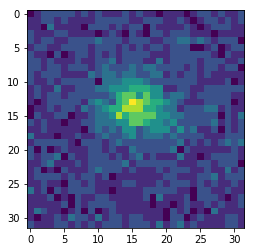

In [5]:
plt.imshow(X_train[170000,...,4,0])

In [6]:

def identity_block(X, f, filters, stage, block):
    """    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_D_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_D, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv3D(filters = F1, kernel_size = 1, strides = 1, padding = 'valid', kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = -1, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv3D(filters=F2, kernel_size= f, padding='same', kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), name= conv_name_base+'2b')(X)
    X = BatchNormalization(axis=3, name= bn_name_base+'2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv3D(filters=F3, kernel_size=1, padding='valid', kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), name=conv_name_base+'2c')(X)
    X = BatchNormalization(axis=-1, name=bn_name_base+'2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])#X+X_shortcut
    X = Activation('relu')(X)
    
    return X

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_D_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_D, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv3D(F1, 1, strides = s, kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = -1, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv3D(F2, f, kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), padding='same', name=conv_name_base+'2b')(X)
    X = BatchNormalization(axis=-1, name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv3D(F3, 1, kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), name=conv_name_base+'2c')(X)
    X = BatchNormalization(axis=-1, name=bn_name_base+'2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv3D(F3, 1, strides=s, kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), name=conv_name_base+'1')(X_shortcut)
    X_shortcut = BatchNormalization(axis=-1, name=bn_name_base+'1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut]) #X+X_shortcut
    X = Activation('relu')(X)
    
    X = Dropout(rate=0.4, name='drop'+str(stage)+block)(X)
    
    return X

def conv_res_3d_model(input_shape=(32,32,8,1)):
    
    X_input = Input(input_shape)

    X = Conv3D(64, 3, padding='same', kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), activation='relu', name='conv1_1')(X_input)
    X = Conv3D(64, 3, padding='same', kernel_constraint=MaxNorm(4., axis=[0,1,2,3]), activation='relu', name='conv1_2')(X)
    X = MaxPooling3D(name='pool1')(X)
    print('conv1\t',X.get_shape())
    
    #X = Dropout(rate=0.3, name='drop_start')(X)
    
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    print('conv2\t',X.get_shape())
    
    X = Dropout(rate=0.7, name='drop_middle')(X)
    
    X = convolutional_block(X, f = 3, filters = [128,128, 512], stage = 3, block='a')
    X = identity_block(X, 3, [128,128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128,128, 512], stage=3, block='c')
    X = MaxPooling3D(padding='same', name='pool3')(X)
    print('conv3\t',X.get_shape())
    
    X = Dropout(rate=0.7, name='drop')(X)
    
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='class')(X)
    
    return Model(inputs = X_input, outputs = X, name='conv_res_model')

conv4_3d_res = conv_res_3d_model(input_shape=X_train.shape[1:])
conv4_3d_res.load_weights('networks/conv4_3d_res_v1_e150.h5', by_name=True)

adamka = optimizers.Adam(lr=3e-5, decay=1e-3, beta_1=0.95)
conv4_3d_res.compile(optimizer=adamka, loss='binary_crossentropy')


#conv4_3d_res = load_model('networks/conv4_3d_res_v0.h5')

conv1	 (?, 16, 16, 4, 64)
conv2	 (?, 8, 8, 2, 256)
conv3	 (?, 2, 2, 1, 512)


In [7]:
#hist_roc = call_roc_hist()
#hist = conv4_3d_res.fit(x=X_train, y=y_train, batch_size=128, epochs=10, validation_split=0.1, callbacks=[hist_roc])
reducer = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1, epsilon=0.0015, min_lr=1e-9)
hist_roc = call_roc_hist()
hist = conv4_3d_res.fit(x=X_train, y=y_train, batch_size=128, epochs=1, validation_split=0.1, callbacks=[hist_roc, reducer])

Train on 212942 samples, validate on 23661 samples
Epoch 1/1
212864/212942 [============================>.] - ETA: 0s - loss: 0.0574
 0 	roc_auc: 0.9938236112661325 

212942/212942 [==============================] - 1214s - loss: 0.0574 - val_loss: 0.2933


In [8]:
preds = conv4_3d_res.predict(X_test,batch_size=64, verbose=1)
print('roc_auc:\t',round(roc_auc_score(y_test, preds), 5))

41754/41754 [==============================] - 62s    
roc_auc:	 0.99315


In [9]:
#Saving the model, short description of training and the outputs
_ = '''conv4_3d_res.save('networks/conv4_3d_res_v1_e150.h5')
with open('networks/notes_conv4_3d_res.txt','a') as ftxt:
    ftxt.write('\nv1:\t Epoch 125-150, -//-, signal C60 instead of C100')
np.savetxt('outputs/conv4_3d_res/v1_roc-auc_150.txt', hist_roc_150.val_aucs)
np.savetxt('outputs/conv4_3d_res/v1_loss_train_150.txt', hist_150.history['loss'])
np.savetxt('outputs/conv4_3d_res/v1_loss_val_150.txt', hist_150.history['val_loss'])'''